# Sample 9.1 Linear regression model to re-invent Hubble's law

In [2]:
%matplotlib inline
#posteior distribution of binomial data
import numpy as np
import numpy.linalg as nl
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
import scipy.special as special
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     36.44
Date:                Tue, 24 May 2022   Prob (F-statistic):           4.48e-06
Time:                        01:32:55   Log-Likelihood:                -163.83
No. Observations:                  24   AIC:                             331.7
Df Residuals:                      22   BIC:                             334.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -40.7836     83.439     -0.489      0.6

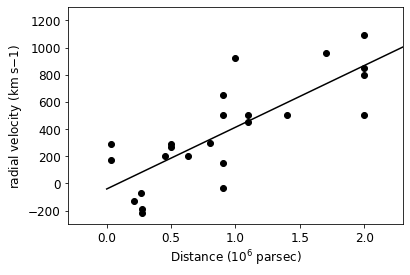

In [3]:
#Original data from Hubble (1929)
v=np.array([170.,290.,-130.,-70.,-185.,\
  -220.,200.,290.,270.,200.,\
  300.,-30.,650.,150.,500.,\
  920.,450.,500.,500.,960.,\
  500.,850.,800.,1090])
r=np.array([0.032,0.034,0.214,0.263,0.275,\
  0.275,0.45,0.5,0.5,0.63,\
  0.8,0.9,0.9,0.9,0.9,\
  1.0,1.1,1.1,1.4,1.7,\
  2.0,2.0,2.0,2.0])
v2=np.array([650.,-25.,1800.,1300.,300.,\
   800.,700.,400.,600.,290.,\
   600.,940.,810.,600.,730.,\
   800.,800.,580.,1100.,1140.,\
   900.,650.])
r2=np.array([1.52,-999,3.45,2.37,0.62,\
   1.16,1.42,0.67,1.24,0.79,\
   1.00,1.74,1.49,1.10,1.27,\
   1.53,1.79,1.20,2.35,2.23,\
   2.06,1.73])

#classical linear regression
def linear(x,a,b):
    return x*a+b

#classical linear regression
def regression_stat(x,y):
    N = x.shape[0]
    if len(x.shape)==1:
        ncols = 2
    else:
        ncols = 1+x.shape[1]
    #x = x.reshape(N)
    X = np.zeros((N, ncols))
    X[:,0] = np.ones_like((N,))
    if ncols == 2:
        X[:,1] = x
    else:
        for i in range(1,ncols):
            X[:,i]=x[:,i-1]
    
    model1 = sm.OLS(y, X)
    resul1 = model1.fit()
    print(resul1.summary())
    return resul1

m = regression_stat(r,v)
for i in range(len(m.params)):
    print('%(v).3f+/-%(e).3f' % {'v':m.params[i],'e':m.bse[i]})
print('RMS:',np.sqrt(np.sum((m.predict()-v)**2)/(len(v)-1)))
popt, pcov = curve_fit(linear, r, v)
print('Classical linear fitting:')
print('H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': popt[0], 'd': np.sqrt(pcov[0,0])})
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r,v,'ko')
ax.plot([0,15],linear(np.array([0,15]),popt[0],popt[1]),'k-')
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_ylabel(r'radial velocity (km s${-1}$)',\
             fontsize=12)
ax.set_xlim([-0.3,2.3])
ax.set_ylim([-300,1300])
fig.show()

(24, 2)
[[ 0.12833882 -0.09510043]
 [-0.09510043  0.1043483 ]]
[-40.7836491  454.15844092]
54247.380285097286
-10.58473847005323
19392 1


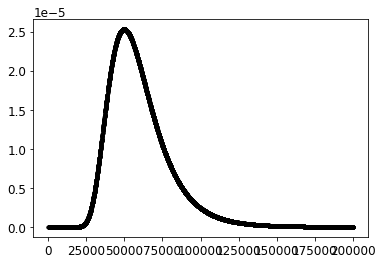

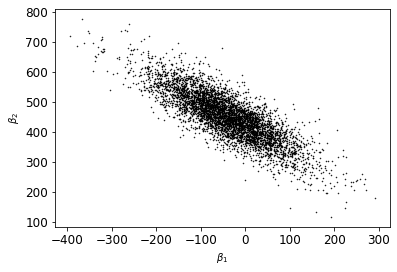

In [4]:
#Solve with Bayesian normal linear regression
def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x

def Scl_InvChi2ln(x, nu, s2):
    return InvGammaln(x, nu/2.,nu/2.*s2)

def randDraw_SInvChi2(nu,s2, N, \
    xmin=100., xmax=2e5, ymin=0., ymax=1, dy=-10.58):
    x = []
    k = 0
    m = 0
    while k<N and m <= 10:
        x0 = np.random.uniform(low=xmin,\
                    high=xmax,size=N*20)
        y0 = np.log(np.random.uniform(\
                    low=ymin,high=ymax,size=N*20))
        y1 = Scl_InvChi2ln(x0, nu, s2)-dy
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        print(k,m)
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])


n = len(v)
k = 2
y = v
X = np.array([np.ones((n,)),r]).T
print(np.shape(X))
V_beta = nl.inv(np.dot(X.T,X))
beta_hat = np.dot(np.dot(V_beta,X.T),y)
s2 = 1./(n-k)*np.dot((y-np.dot(X,beta_hat)).T,\
            (y-np.dot(X,beta_hat)))
print(V_beta)
print(beta_hat)
print(s2)

#test Inv-chi2 to find proper range of y
xx = np.random.uniform(low=100,high=2e5,size=10000)
yy = Scl_InvChi2ln(xx, n-k, s2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xx,np.exp(yy),'k.')
#ax.set_ylim([-100,0])
fig.show()

print(np.max((yy)))

#step 1: draw sigma from Inv-Chi2
N = 5000
sigma2 = randDraw_SInvChi2(n-k,s2, N)
#step 2: draw beta from N(beta_hat, V_beta*sigma^2)
beta = np.array([np.random.\
    multivariate_normal(beta_hat,\
    V_beta*sigma2[i])  for i in range(N)])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(beta[:,0],beta[:,1],'k.',markersize=1)
ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\beta_2$')
fig.show()

Classical linear fitting:
H_0=454.2+/-75.2 km/s/Mpc
Bayesian linear regression:
H_0=453.5+/-80.3 km/s/Mpc
sigma=240.9+/-37.3 km/s


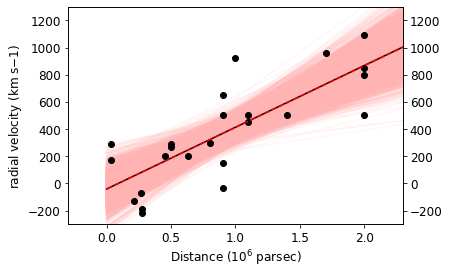

In [5]:
#show result and random draw in d-v plane
popt, pcov = curve_fit(linear, r, v)
print ('Classical linear fitting:')
print ('H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': popt[0], 'd': np.sqrt(pcov[0,0])})
    
print ('Bayesian linear regression:')
print ('H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': np.mean(beta[:,1]),\
    'd': np.std(beta[:,1])})
print ('sigma=%(h).1f+/-%(d).1f km/s' %\
    {'h': np.mean(np.sqrt(sigma2)),\
    'd': np.std(np.sqrt(sigma2))})
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([0,15],linear(np.array([0,15]),\
    beta[i,1], beta[i,0]),'-',\
           color=[1.0,0.7,0.7],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot(r,v,'ko')
ax1.plot([0,15],linear(np.array([0,15]),\
    popt[0],popt[1]),'k-')
ax1.plot([0,15],linear(np.array([0,15]),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'r--')
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_ylabel(r'radial velocity (km s${-1}$)',\
             fontsize=12)
ax.set_xlim([-0.3,2.3])
ax.set_ylim([-300,1300])
ax1.set_xlim([-0.3,2.3])
ax1.set_ylim([-300,1300])
fig.show()

In [8]:
#Prediction for new data
X_tilde=np.array([np.ones((100,)),\
                  np.arange(0,2.3,0.023)]).T

E_y_tilde = np.dot(X_tilde,beta_hat)
print ((E_y_tilde))
D_y_tilde = np.diag((np.diag(np.ones((100,)))\
        +np.dot(np.dot(X_tilde,V_beta),\
        X_tilde.T))*np.mean(sigma2))
print ((D_y_tilde))

[-40.7836491  -30.33800495 -19.89236081  -9.44671667   0.99892747
  11.44457161  21.89021575  32.33585989  42.78150403  53.22714818
  63.67279232  74.11843646  84.5640806   95.00972474 105.45536888
 115.90101302 126.34665716 136.7923013  147.23794545 157.68358959
 168.12923373 178.57487787 189.02052201 199.46616615 209.91181029
 220.35745443 230.80309858 241.24874272 251.69438686 262.140031
 272.58567514 283.03131928 293.47696342 303.92260756 314.36825171
 324.81389585 335.25953999 345.70518413 356.15082827 366.59647241
 377.04211655 387.48776069 397.93340484 408.37904898 418.82469312
 429.27033726 439.7159814  450.16162554 460.60726968 471.05291382
 481.49855797 491.94420211 502.38984625 512.83549039 523.28113453
 533.72677867 544.17242281 554.61806695 565.06371109 575.50935524
 585.95499938 596.40064352 606.84628766 617.2919318  627.73757594
 638.18322008 648.62886422 659.07450837 669.52015251 679.96579665
 690.41144079 700.85708493 711.30272907 721.74837321 732.19401735
 742.6396615

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


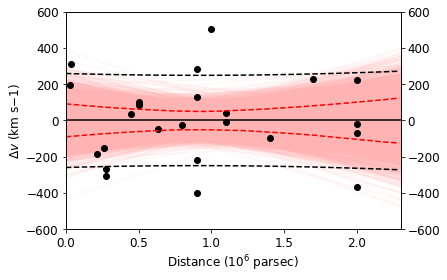

In [9]:
#Using the grid prediction 
# check the robustness of the model
r_grid = np.arange(0,2.3,0.01)
v_lower = np.zeros(np.shape(r_grid))
v_upper = np.zeros(np.shape(r_grid))
v_mean = np.zeros(np.shape(r_grid))
v_N = np.zeros((len(r_grid),N))
for i in range(N):
    v_N[:,i] = linear(r_grid,\
    beta[i,1], beta[i,0])
for j in range(len(r_grid)):
    v_lower[j] = np.percentile(v_N[j,:],15)
    v_upper[j] = np.percentile(v_N[j,:],85)
    v_mean[j] = np.mean(v_N[j,:])
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(N):
    ax.plot([0,1500],linear(np.array([0,1500]),\
    beta[i,1], beta[i,0])-\
    linear(np.array([0,1500]),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'-',\
           color=[1.0,0.7,0.7],alpha=0.1)
    
ax1 = ax.twinx()
ax1.plot(r,v-linear(np.array(r),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'ko')
ax1.plot([0,1500],[0,0],'k-')
ax1.plot(X_tilde[:,1],+np.sqrt(D_y_tilde),'k--')
ax1.plot(X_tilde[:,1],-np.sqrt(D_y_tilde),'k--')
ax1.plot(r_grid,v_lower-v_mean,'r--')
ax1.plot(r_grid,v_upper-v_mean,'r--')
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_ylabel(r'$\Delta v$ (km s${-1}$)',\
             fontsize=12)
ax.set_xlim([-0.,2.3])
ax.set_ylim([-600,600])
ax1.set_xlim([-0.,2.3])
ax1.set_ylim([-600,600])
fig.show()

[[ 0.0840806  -0.0465384 ]
 [-0.0465384   0.05106394]]
[-68.16757025 484.20526156]
52625.462578471386
-10.533694862329515
19438 1


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


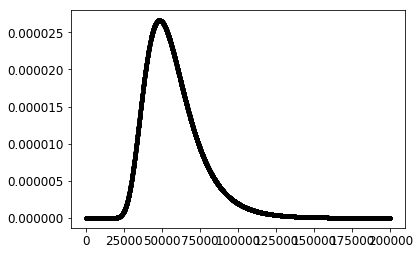

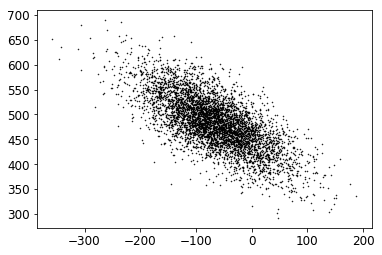

In [11]:
#Solve with Bayesian normal linear regression
# Now add prior for a, which follows
# normal distribution centered at 513. with std.
# of 60
nast = len(v)+1
k = 2
r1 = np.append(r,1.0)
X_ast = np.array([np.ones((nast,)),r1]).T
X_ast[-1,0]=0.
#consider a prior for the slope
y_ast = np.append(v,513.)


Q_y = np.diag(np.ones((nast,)))
Q_y[-1,-1] = 0.1
iQ_y = nl.inv(Q_y)
Vast_beta = nl.inv(np.dot(np.dot(X_ast.T,iQ_y),X_ast))
betaast_hat = np.dot(np.dot(np.dot(Vast_beta,X_ast.T),iQ_y),y_ast)
s2ast = 1./(nast-k)*np.dot(np.dot((y_ast-np.dot(X_ast,betaast_hat)).T,\
        iQ_y),(y_ast-np.dot(X_ast,betaast_hat)))
print (Vast_beta)
print (betaast_hat)
print (s2ast)

#test Inv-chi2 to find proper range of y
xx = np.random.uniform(low=100,high=2e5,size=10000)
yy = Scl_InvChi2ln(xx, nast-k, s2ast)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xx,np.exp(yy),'k.')
#ax.set_ylim([-100,0])
fig.show()

print (np.max((yy)))

#step 1: draw sigma from Inv-Chi2
N = 5000
sigma2_ast = randDraw_SInvChi2(nast-k,s2ast, N)
#step 2: draw beta from N(beta_hat, V_beta*sigma^2)
beta_ast = np.array([np.random.\
        multivariate_normal(betaast_hat,\
        Vast_beta*sigma2_ast[i])  for i in range(N)])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(beta_ast[:,0],beta_ast[:,1],'k.',markersize=1)
fig.show()

Classical linear fitting:
H_0=454.2+/-75.2 km/s/Mpc
Bayesian linear regression:
H_0=453.1+/-79.0 km/s/Mpc
sigma=241.5+/-37.6 km/s/Mpc
Bayesian linear regression with prior:
H_0=483.4+/-54.2 km/s/Mpc
sigma=237.1+/-36.2 km/s/Mpc


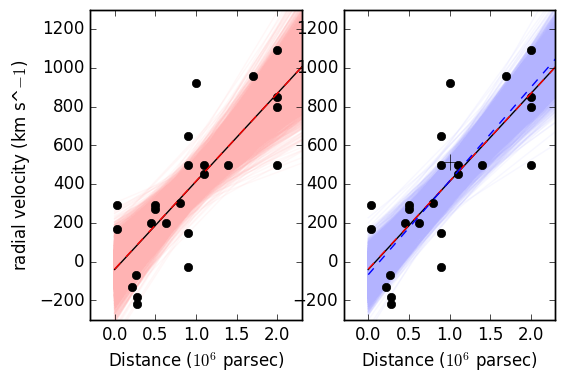

In [319]:
#Draw result in d-v plane
popt, pcov = curve_fit(linear, r, v)
print 'Classical linear fitting:'
print 'H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': popt[0], 'd': np.sqrt(pcov[0,0])}
    
print 'Bayesian linear regression:'
print 'H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': np.mean(beta[:,1]),\
    'd': np.std(beta[:,1])}
print 'sigma=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': np.mean(np.sqrt(sigma2)),\
    'd': np.std(np.sqrt(sigma2))}
    
print 'Bayesian linear regression with prior:'
print 'H_0=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': np.mean(beta_ast[:,1]),\
    'd': np.std(beta_ast[:,1])}
print 'sigma=%(h).1f+/-%(d).1f km/s/Mpc' %\
    {'h': np.mean(np.sqrt(sigma2_ast)),\
    'd': np.std(np.sqrt(sigma2_ast))}
    
    
fig = plt.figure()
ax = fig.add_subplot(121)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([0,15],linear(np.array([0,15]),\
    beta[i,1], beta[i,0]),'-',\
           color=[1.0,0.7,0.7],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot(r,v,'ko')
ax1.plot([0,15],linear(np.array([0,15]),\
    popt[0],popt[1]),'k-')
ax1.plot([0,15],linear(np.array([0,15]),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'r--')
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_ylabel(r'radial velocity (km s^${-1}$)',\
             fontsize=12)
ax.set_xlim([-0.3,2.3])
ax.set_ylim([-300,1300])
ax1.set_xlim([-0.3,2.3])
ax1.set_ylim([-300,1300])
ax1.set_yticklabels([])
##########################
ax = fig.add_subplot(122)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([0,15],linear(np.array([0,15]),\
    beta_ast[i,1], beta_ast[i,0]),'-',\
           color=[0.7,0.7,1,],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot(r,v,'ko')
ax1.plot([0,15],linear(np.array([0,15]),\
    popt[0],popt[1]),'k-')
ax1.plot([0,15],linear(np.array([0,15]),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'r--')
ax1.plot([0,15],linear(np.array([0,15]),\
    np.mean(beta_ast[:,1]), np.mean(beta_ast[:,0])),'b--')
ax.plot(1.0,513,'k+',markersize=12)
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_xlim([-0.3,2.3])
ax.set_ylim([-300,1300])
ax1.set_xlim([-0.3,2.3])
ax1.set_ylim([-300,1300])
ax1.set_yticklabels([])
fig.show()

(100, 2)
(100,)


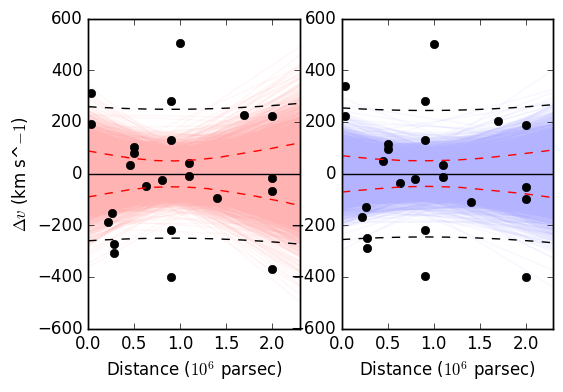

In [320]:
#robustness check for the result
X_tilde=np.array([np.ones((100,)),np.arange(0,2.3,0.023)]).T
print np.shape(X_tilde)
E_yast_tilde = np.dot(X_tilde,betaast_hat)
D_yast_tilde = np.diag((np.diag(np.ones((100,)))+\
    np.dot(np.dot(X_tilde,V_beta),X_tilde.T))*np.mean(sigma2_ast))
print np.shape(D_y_tilde)

r_grid = np.arange(0,2.3,0.01)
vast_lower = np.zeros(np.shape(r_grid))
vast_upper = np.zeros(np.shape(r_grid))
vast_mean = np.zeros(np.shape(r_grid))
vast_N = np.zeros((len(r_grid),N))
for i in range(N):
    vast_N[:,i] = linear(r_grid,\
    beta_ast[i,1], beta_ast[i,0])
for j in range(len(r_grid)):
    vast_lower[j] = np.percentile(vast_N[j,:],15)
    vast_upper[j] = np.percentile(vast_N[j,:],85)
    vast_mean[j] = np.mean(vast_N[j,:])
    
fig = plt.figure()
ax = fig.add_subplot(121)
for i in range(N):
    ax.plot([0,1500],linear(np.array([0,1500]),\
    beta[i,1], beta[i,0])-\
    linear(np.array([0,1500]),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'-',\
           color=[1.0,0.7,0.7],alpha=0.1)
    
ax1 = ax.twinx()
ax1.plot(r,v-linear(np.array(r),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'ko')
ax1.plot([0,1500],[0,0],'k-')
ax1.plot(X_tilde[:,1],+np.sqrt(D_y_tilde),'k--')
ax1.plot(X_tilde[:,1],-np.sqrt(D_y_tilde),'k--')
ax1.plot(r_grid,v_lower-v_mean,'r--')
ax1.plot(r_grid,v_upper-v_mean,'r--')
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_ylabel(r'$\Delta v$ (km s^${-1}$)',\
             fontsize=12)
ax.set_xlim([-0.,2.3])
ax.set_ylim([-600,600])
ax1.set_xlim([-0.,2.3])
ax1.set_ylim([-600,600])
ax1.set_yticklabels([])
#############################

ax = fig.add_subplot(122)
for i in range(N):
    ax.plot([0,1500],linear(np.array([0,1500]),\
    beta_ast[i,1], beta_ast[i,0])-\
    linear(np.array([0,1500]),\
    np.mean(beta_ast[:,1]), np.mean(beta_ast[:,0])),'-',\
           color=[0.7,0.7,1.0],alpha=0.1)
    
ax1 = ax.twinx()
ax1.plot(r,v-linear(np.array(r),\
    np.mean(beta_ast[:,1]), np.mean(beta_ast[:,0])),'ko')
ax1.plot([0,1500],[0,0],'k-')
ax1.plot(X_tilde[:,1],+np.sqrt(D_yast_tilde),'k--')
ax1.plot(X_tilde[:,1],-np.sqrt(D_yast_tilde),'k--')
ax1.plot(r_grid,vast_lower-vast_mean,'r--')
ax1.plot(r_grid,vast_upper-vast_mean,'r--')
ax.set_xlabel(r'Distance ($10^6$ parsec)',\
              fontsize=12)
ax.set_xlim([-0.,2.3])
ax.set_ylim([-600,600])
ax1.set_xlim([-0.,2.3])
ax1.set_ylim([-600,600])
ax1.set_yticklabels([])
fig.show()

## Lets re-do something won Nobel prize

Classical linear regression:
low-z Slope=5.1103+/-0.1184
Classical linear regression:
high-z Slope=6.0660+/-0.6070


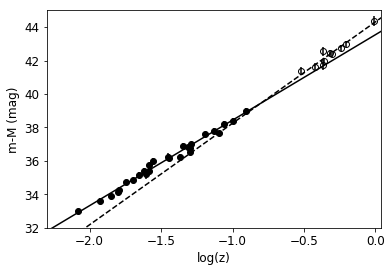

In [4]:
#lets try Nobel-prize work: Riess et al. (1998)
hdulist = fits.open('Riess1998_tab10.fits')
lowz_data = hdulist[1].data

hdulist = fits.open('Riess1998_tab05.fits')
highz_data = hdulist[1].data
#red shift
z_low = 10**(lowz_data.log_cz)/300000
z_high = highz_data.z
#distance moduli
dm_low = lowz_data.Mu_0
dm_high = highz_data.Mu_0
#error of distance moduli
dmerr_low = lowz_data.Sig_mu
dmerr_high = highz_data.Sig_mu
#combine low- and high-redshift data
z = np.concatenate((z_low,z_high))
dm = np.concatenate((dm_low,dm_high))
dm_err = np.concatenate((dmerr_low,dmerr_high)) 

#Classical regression by curve fitting
popt_low, pcov_low = curve_fit(\
                linear,np.log10(z_low) , dm_low)
print 'Classical linear regression:'
print 'low-z Slope=%(h).4f+/-%(d).4f' %\
    {'h': popt_low[0], 'd': np.sqrt(pcov_low[0,0])}
popt_high, pcov_high = curve_fit(\
                linear,np.log10(z_high) , dm_high)
print 'Classical linear regression:'
print 'high-z Slope=%(h).4f+/-%(d).4f' %\
    {'h': popt_high[0], 'd': np.sqrt(pcov_high[0,0])}
    
#Draw plot of redshift vs. dm
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(np.log10(z_low),dm_low,yerr=dmerr_low,\
            fmt='ko',markerfacecolor='k')
ax.errorbar(np.log10(z_high),dm_high,yerr=dmerr_high,\
            fmt='ko',markerfacecolor='none')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
                        popt_low[0],popt_low[1]),'k-')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
                        popt_high[0],popt_high[1]),'k--')
ax.set_xlabel(r'log(z)',\
              fontsize=12)
ax.set_ylabel(r'm-M (mag)',\
             fontsize=12)
ax.set_xlim(np.log10([0.005,1.1]))
ax.set_ylim([32,45])
fig.show()

(37, 2)
[[ 0.13566578  0.0939085 ]
 [ 0.0939085   0.08117551]]
[ 44.06138551   5.44651785]
0.0487138077614
3.55723545971
60410 1


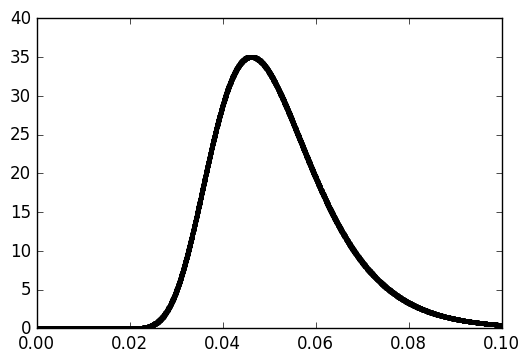

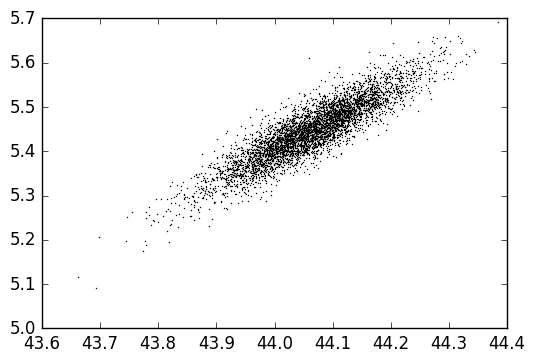

In [322]:
#linear regression with only low-z data
def Bayes_linearreg(n,k,beta_hat, V_beta, s2, N,\
                   xmin=0.,xmax=0.1,ymin=0.0,ymax=3.79,dy=0.):
    #step 1: draw sigma from Inv-Chi2
    N = 5000
    sigma2 = randDraw_SInvChi2(n-k,s2, N,\
                xmin=xmin,xmax=xmax,\
                ymin=ymin,ymax=ymax,dy=dy)
    #step 2: draw beta from N(beta_hat, V_beta*sigma^2)
    beta = np.array([np.random.\
        multivariate_normal(beta_hat,\
        V_beta*sigma2[i])  for i in range(N)])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(beta[:,0],beta[:,1],'k.',markersize=1)
    fig.show()
    return sigma2, beta   


############################   
n = len(z)
k = 2
y = dm
X = np.array([np.ones((n,)),np.log10(z)]).T
print np.shape(X)
V_beta = nl.inv(np.dot(X.T,X))
beta_hat = np.dot(np.dot(V_beta,X.T),y)
s2 = 1./(n-k)*np.dot((y-np.dot(X,beta_hat)).T,\
            (y-np.dot(X,beta_hat)))
print(V_beta)
print(beta_hat)
print(s2)

#test Inv-chi2 to find proper range of y
xx = np.random.uniform(low=0,high=0.1,size=10000)
yy = Scl_InvChi2ln(xx, n-k, s2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xx,np.exp(yy),'k.')
#ax.set_ylim([-100,0])
fig.show()

print(np.max((yy)))

sigma2, beta = Bayes_linearreg\
    (n,k,beta_hat, V_beta, s2, N)

=======  all z  =========
Classical linear regression:
low-z Slope=5.4465+/-0.0629
Bayesian linear regression:
slope=5.447+/-0.068 
sigma=0.237+/-0.039 


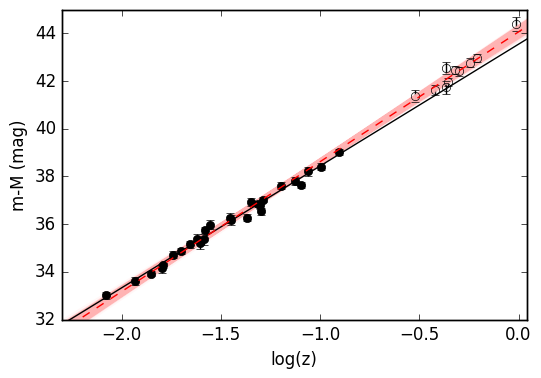

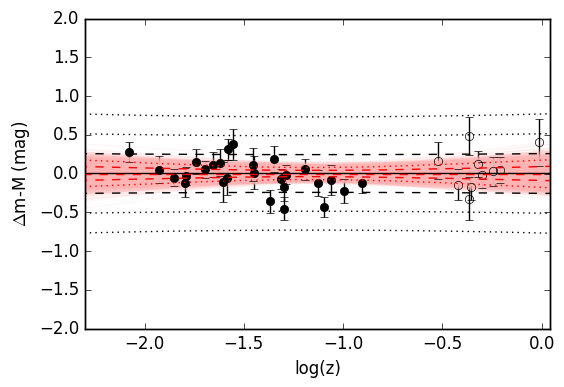

In [323]:
#Draw result in d-v plane

popt, pcov = curve_fit(linear,np.log10(z) , dm)
print '=======  all z  ========='
print 'Classical linear regression:'
print 'low-z Slope=%(h).4f+/-%(d).4f' %\
    {'h': popt[0], 'd': np.sqrt(pcov[0,0])}
    
print 'Bayesian linear regression:'
print 'slope=%(h).3f+/-%(d).3f ' %\
    {'h': np.mean(beta[:,1]),\
    'd': np.std(beta[:,1])}
print 'sigma=%(h).3f+/-%(d).3f ' %\
    {'h': np.mean(np.sqrt(sigma2)),\
    'd': np.std(np.sqrt(sigma2))}



#draw result    
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([-3,0.5],linear(np.array([-3,0.5]),\
    beta[i,1], beta[i,0]),'-',\
           color=[1.0,0.7,0.7],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot([-3,0.5],linear(np.array([-3,0.5]),\
    np.mean(beta[:,1]), np.mean(beta[:,0])),'r--')
ax.errorbar(np.log10(z_low),dm_low,yerr=dmerr_low,\
            fmt='ko',markerfacecolor='k')
ax.errorbar(np.log10(z_high),dm_high,yerr=dmerr_high,\
            fmt='ko',markerfacecolor='none')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
                        popt_low[0],popt_low[1]),'k-')

ax.set_xlabel(r'log(z)',\
              fontsize=12)
ax.set_ylabel(r'm-M (mag)',\
             fontsize=12)
ax.set_xlim(np.log10([0.005,1.1]))
ax.set_ylim([32,45])
ax1.set_xlim(np.log10([0.005,1.1]))
ax1.set_ylim([32,45])
ax1.set_yticklabels([])
fig.show()

###############################
#robustness check for the result
#Prediction for new data
X_tilde=np.array([np.ones((300,)),\
                  np.arange(-2.5,0.5,0.01)]).T
#print np.shape(X_tilde)
E_y_tilde = np.dot(X_tilde,beta_hat)
D_y_tilde = np.diag((np.diag(np.ones((300,)))\
        +np.dot(np.dot(X_tilde,V_beta),\
        X_tilde.T))*np.mean(sigma2))
#print np.shape(D_y_tilde)

#Using the grid prediction 
# check the robustness of the model
logz_grid = np.arange(-2.5,0.5,0.01)
v_lower = np.zeros(np.shape(logz_grid))
v_upper = np.zeros(np.shape(logz_grid))
v_2lower = np.zeros(np.shape(logz_grid))
v_2upper = np.zeros(np.shape(logz_grid))
v_mean = np.zeros(np.shape(logz_grid))
v_N = np.zeros((len(logz_grid),N))
for i in range(N):
    v_N[:,i] = linear(logz_grid,\
    beta[i,1], beta[i,0])
for j in range(len(logz_grid)):
    v_lower[j] = np.percentile(v_N[j,:],15)
    v_upper[j] = np.percentile(v_N[j,:],85)
    v_2lower[j] = np.percentile(v_N[j,:],2.5)
    v_2upper[j] = np.percentile(v_N[j,:],97.5)
    v_mean[j] = np.mean(v_N[j,:])

#residual    
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([-3,0.5],linear(np.array([-3,0.5]),\
    np.mean(beta[:,1]), np.mean(beta[:,0]))-\
            linear(np.array([-3,0.5]),\
    beta[i,1], beta[i,0]),'-',\
           color=[1.0,0.7,0.7],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot([-3,0.5],[0,0],'r--')
ax.errorbar(np.log10(z_low),dm_low-\
            linear(np.log10(z_low),\
            np.mean(beta[:,1]), \
            np.mean(beta[:,0]))\
            ,yerr=dmerr_low,\
            fmt='ko',markerfacecolor='k')
ax.errorbar(np.log10(z_high),dm_high-\
            linear(np.log10(z_high),\
            np.mean(beta[:,1]),np.mean(beta[:,0]))\
            ,yerr=dmerr_high,\
            fmt='ko',markerfacecolor='none')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
        np.mean(beta[:,1]), np.mean(beta[:,0]))-\
        linear(np.array([-2.5,1]),\
        popt[0],popt[1]),'k-')
ax1.plot(X_tilde[:,1],+np.sqrt(D_y_tilde),'k--')
ax1.plot(X_tilde[:,1],-np.sqrt(D_y_tilde),'k--')
ax1.plot(X_tilde[:,1],+2*np.sqrt(D_y_tilde),'k:')
ax1.plot(X_tilde[:,1],-2*np.sqrt(D_y_tilde),'k:')
ax1.plot(X_tilde[:,1],+3*np.sqrt(D_y_tilde),'k:')
ax1.plot(X_tilde[:,1],-3*np.sqrt(D_y_tilde),'k:')
ax1.plot(logz_grid,v_lower-v_mean,'r--')
ax1.plot(logz_grid,v_upper-v_mean,'r--')
ax1.plot(logz_grid,v_2lower-v_mean,'r:')
ax1.plot(logz_grid,v_2upper-v_mean,'r:')
ax.set_xlabel(r'log(z)',\
              fontsize=12)
ax.set_ylabel(r'$\Delta$m-M (mag)',\
             fontsize=12)
ax.set_xlim(np.log10([0.005,1.1]))
ax.set_ylim([-2,2])
ax1.set_xlim(np.log10([0.005,1.1]))
ax1.set_ylim([-2,2])
ax1.set_yticklabels([])
fig.show()



=======  low-z  =========
Classical linear regression:
low-z Slope=5.1103+/-0.1184
Bayesian linear regression:
slope=5.109+/-0.135 
sigma=0.205+/-0.041 
(37, 2)
[[ 0.95150883  0.62214807]
 [ 0.62214807  0.42326972]]
[ 43.54517381   5.11032383]
0.0330964463721
3.78456337418
52434 1


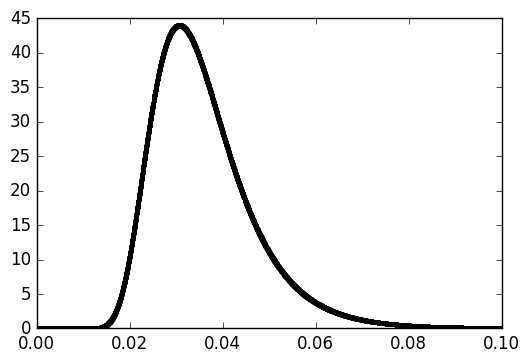

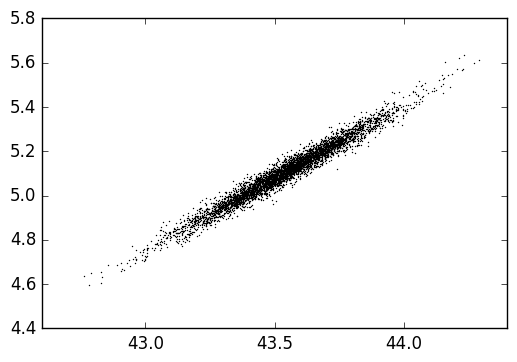

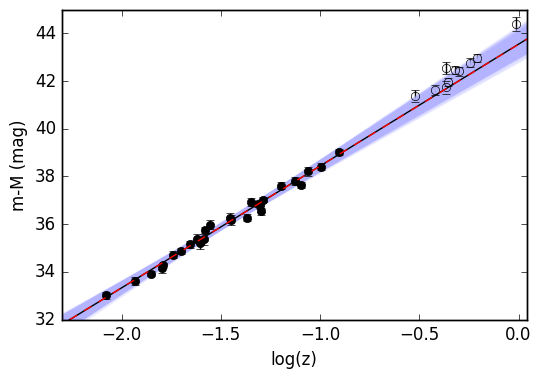

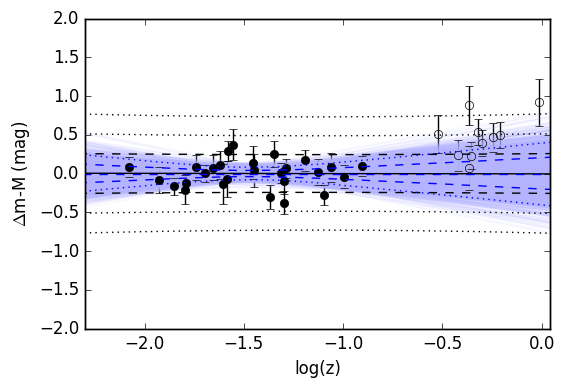

In [325]:
# only fit low-z data
    ####################################
popt_low, pcov_low = curve_fit(linear,np.log10(z_low) , dm_low)
print '=======  low-z  ========='
print 'Classical linear regression:'
print 'low-z Slope=%(h).4f+/-%(d).4f' %\
    {'h': popt_low[0], 'd': np.sqrt(pcov_low[0,0])}
    
print 'Bayesian linear regression:'
print 'slope=%(h).3f+/-%(d).3f ' %\
    {'h': np.mean(beta_low[:,1]),\
    'd': np.std(beta_low[:,1])}
print 'sigma=%(h).3f+/-%(d).3f ' %\
    {'h': np.mean(np.sqrt(sigma2_low)),\
    'd': np.std(np.sqrt(sigma2_low))}

n_low = len(z_low)
k = 2
y_low = dm_low
X_low = np.array([np.ones((n_low,)),np.log10(z_low)]).T
print np.shape(X)
V_beta_low = nl.inv(np.dot(X_low.T,X_low))
beta_hat_low = np.dot(np.dot(V_beta_low,X_low.T),y_low)
s2_low = 1./(n_low-k)*np.dot((y_low-np.dot(X_low,beta_hat_low)).T,\
            (y_low-np.dot(X_low,beta_hat_low)))
print V_beta_low
print beta_hat_low
print s2_low

#test Inv-chi2 to find proper range of y
xx = np.random.uniform(low=0,high=0.1,size=10000)
yy = Scl_InvChi2ln(xx, n_low-k, s2_low)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xx,np.exp(yy),'k.')
#ax.set_ylim([-100,0])
fig.show()

print np.max((yy))

sigma2_low, beta_low = Bayes_linearreg\
    (n_low,k,beta_hat_low, V_beta_low, s2_low, N)
    
#draw result    
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([-3,0.5],linear(np.array([-3,0.5]),\
    beta_low[i,1], beta_low[i,0]),'-',\
           color=[0.7,0.7,1.0],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot([-3,0.5],linear(np.array([-3,0.5]),\
    np.mean(beta_low[:,1]), np.mean(beta_low[:,0])),'r--')
ax.errorbar(np.log10(z_low),dm_low,yerr=dmerr_low,\
            fmt='ko',markerfacecolor='k')
ax.errorbar(np.log10(z_high),dm_high,yerr=dmerr_high,\
            fmt='ko',markerfacecolor='none')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
                        popt_low[0],popt_low[1]),'k-')

ax.set_xlabel(r'log(z)',\
              fontsize=12)
ax.set_ylabel(r'm-M (mag)',\
             fontsize=12)
ax.set_xlim(np.log10([0.005,1.1]))
ax.set_ylim([32,45])
ax1.set_xlim(np.log10([0.005,1.1]))
ax1.set_ylim([32,45])
ax1.set_yticklabels([])
fig.show()

###############################
#robustness check for the result
#Prediction for new data
X_tilde=np.array([np.ones((300,)),\
                  np.arange(-2.5,0.5,0.01)]).T
#print np.shape(X_tilde)
E_y_tilde = np.dot(X_tilde,beta_hat)
D_y_tilde = np.diag((np.diag(np.ones((300,)))\
        +np.dot(np.dot(X_tilde,V_beta),\
        X_tilde.T))*np.mean(sigma2))
#print np.shape(D_y_tilde)

#Using the grid prediction 
# check the robustness of the model
logz_grid = np.arange(-2.5,0.5,0.01)
v_lower = np.zeros(np.shape(logz_grid))
v_upper = np.zeros(np.shape(logz_grid))
v_2lower = np.zeros(np.shape(logz_grid))
v_2upper = np.zeros(np.shape(logz_grid))
v_mean = np.zeros(np.shape(logz_grid))
v_N = np.zeros((len(logz_grid),N))
for i in range(N):
    v_N[:,i] = linear(logz_grid,\
    beta_low[i,1], beta_low[i,0])
for j in range(len(logz_grid)):
    v_lower[j] = np.percentile(v_N[j,:],15)
    v_upper[j] = np.percentile(v_N[j,:],85)
    v_2lower[j] = np.percentile(v_N[j,:],2.5)
    v_2upper[j] = np.percentile(v_N[j,:],97.5)
    v_mean[j] = np.mean(v_N[j,:])

#residual    
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_alpha(0.1)
for i in range(N):
    ax.plot([-3,0.5],linear(np.array([-3,0.5]),\
    np.mean(beta_low[:,1]), np.mean(beta_low[:,0]))-\
            linear(np.array([-3,0.5]),\
    beta_low[i,1], beta_low[i,0]),'-',\
           color=[0.7,0.7,1.0],alpha=0.1)
#for l in ax.lines:
#    l.set_alpha(.3)
ax1 = ax.twinx()
ax1.plot([-3,0.5],[0,0],'b--')
ax.errorbar(np.log10(z_low),dm_low-\
            linear(np.log10(z_low),\
            np.mean(beta_low[:,1]), \
            np.mean(beta_low[:,0]))\
            ,yerr=dmerr_low,\
            fmt='ko',markerfacecolor='k')
ax.errorbar(np.log10(z_high),dm_high-\
            linear(np.log10(z_high),\
            np.mean(beta_low[:,1]),np.mean(beta_low[:,0]))\
            ,yerr=dmerr_high,\
            fmt='ko',markerfacecolor='none')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
        np.mean(beta_low[:,1]), np.mean(beta_low[:,0]))-\
        linear(np.array([-2.5,1]),\
        popt_low[0],popt_low[1]),'k-')
ax1.plot(X_tilde[:,1],+np.sqrt(D_y_tilde),'k--')
ax1.plot(X_tilde[:,1],-np.sqrt(D_y_tilde),'k--')
ax1.plot(X_tilde[:,1],+2*np.sqrt(D_y_tilde),'k:')
ax1.plot(X_tilde[:,1],-2*np.sqrt(D_y_tilde),'k:')
ax1.plot(X_tilde[:,1],+3*np.sqrt(D_y_tilde),'k:')
ax1.plot(X_tilde[:,1],-3*np.sqrt(D_y_tilde),'k:')
ax1.plot(logz_grid,v_lower-v_mean,'b--')
ax1.plot(logz_grid,v_upper-v_mean,'b--')
ax1.plot(logz_grid,v_2lower-v_mean,'b:')
ax1.plot(logz_grid,v_2upper-v_mean,'b:')
ax.set_xlabel(r'log(z)',\
              fontsize=12)
ax.set_ylabel(r'$\Delta$m-M (mag)',\
             fontsize=12)
ax.set_xlim(np.log10([0.005,1.1]))
ax.set_ylim([-2,2])
ax1.set_xlim(np.log10([0.005,1.1]))
ax1.set_ylim([-2,2])
ax1.set_yticklabels([])
fig.show()




Classical linear regression:
cepheid H_0=1.0000+/-inf
SNIa H_0=67.5344+/-1.7265
TF H_0=77.2321+/-3.2625
FP H_0=84.6380+/-4.7538


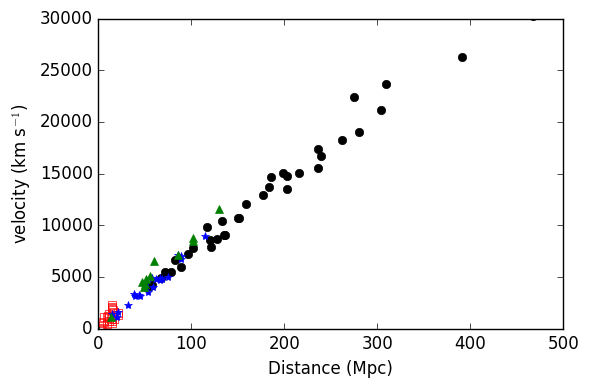

In [326]:
#Freedman et al. (2001) compile different H-const measurement
#measured from cepheid
hdulist = fits.open('Freedman2001_tab4.fits')
cepheid_data = hdulist[1].data
v_cep = cepheid_data.V_CMB
d_cep = cepheid_data.D_0
#measured from SNIa
hdulist = fits.open('Freedman2001_tab6.fits')
SNIa_data = hdulist[1].data
v_snia = SNIa_data.V_CMB
d_snia = SNIa_data.D_Mpc
#measured from Tully-Fisher relation
hdulist = fits.open('Freedman2001_tab7.fits')
TF_data = hdulist[1].data
v_tf = TF_data.V_CMB
d_tf = TF_data.D_Mpc
#measured from Fundamental-plane
hdulist = fits.open('Freedman2001_tab9.fits')
FP_data = hdulist[1].data
v_fp = FP_data.V_CMB
d_fp = FP_data.D_Mpc

#Classical regression by curve fitting
popt_cep, pcov_cep = curve_fit(\
                linear,d_cep,v_cep)
popt_snia, pcov_snia = curve_fit(\
                linear,d_snia,v_snia)
popt_tf, pcov_tf = curve_fit(\
                linear,d_tf,v_tf)
popt_fp, pcov_fp = curve_fit(\
                linear,d_fp,v_fp)
print 'Classical linear regression:'
print 'cepheid H_0=%(h).4f+/-%(d).4f' %\
    {'h': popt_cep[0], 'd': np.sqrt(pcov_cep[0,0])}
print 'SNIa H_0=%(h).4f+/-%(d).4f' %\
    {'h': popt_snia[0], 'd': np.sqrt(pcov_snia[0,0])}
print 'TF H_0=%(h).4f+/-%(d).4f' %\
    {'h': popt_tf[0], 'd': np.sqrt(pcov_tf[0,0])}
print 'FP H_0=%(h).4f+/-%(d).4f' %\
    {'h': popt_fp[0], 'd': np.sqrt(pcov_fp[0,0])}

#Draw plot of redshift vs. dm
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(d_cep,v_cep,'s',markeredgecolor='r',\
        markerfacecolor='none')
ax.plot(d_snia,v_snia,'o',markeredgecolor='k',\
        markerfacecolor='k')
ax.plot(d_tf,v_tf,'*',markeredgecolor='b',\
        markerfacecolor='b')
ax.plot(d_fp,v_fp,'^',markeredgecolor='g',\
        markerfacecolor='g')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
                        popt_low[0],popt_low[1]),'k-')
ax.plot([-2.5,1],linear(np.array([-2.5,1]),\
                        popt_high[0],popt_high[1]),'k--')
ax.set_xlabel(r'Distance (Mpc)',\
              fontsize=12)
ax.set_ylabel(r'velocity (km s$^{-1}$)',\
             fontsize=12)
ax.set_xlim([0,500])
ax.set_ylim([0,3e4])
fig.show()